In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from Image_Sampler import Sampler
from TorchUtils import carlaDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
DATA_PATH = "/disk/vanishing_data/is789/anomaly_samples/Samples_2022-03-31_22:26:47/"

X_train = Sampler.load_Images(DATA_PATH)

batch_size = 64
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

Loaded 37 images | width = 150, height = 150, channels = 3
Shape of training data: (37, 150, 150, 3)
Data type: <class 'numpy.ndarray'>


In [4]:
# data = X_train.astype(np.float32)
# data = 255 * data
# X_train = data.astype(np.uint8)

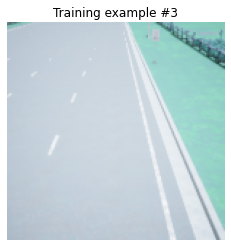

In [5]:
random_image = random.randint(0, len(X_train)-1)
plt.imshow(X_train[random_image])
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

In [6]:
batch_size = 2
learning_rate = 1e-3
num_epochs = 10
transformed_dataset = carlaDataset(X=X_train, image_size=64)
train_dl = DataLoader(transformed_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [7]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

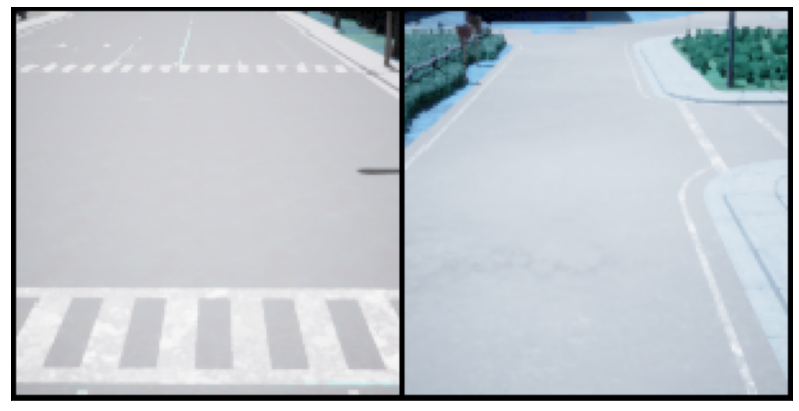

In [8]:
show_batch(train_dl)

In [9]:
for images in train_dl:
    img = images.detach().numpy()
    print(type(img))
    break

<class 'numpy.ndarray'>


In [10]:
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=512*17*17, zDim=1024):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 3)
        self.encConv2 = nn.Conv2d(16, 32, 3)
        self.encConv3 = nn.Conv2d(32, 64, 3)
        self.encConv4 = nn.Conv2d(64, 80, 3)
        self.encConv5 = nn.Conv2d(80, 90, 3)
#         self.encConv6 = nn.Conv2d(256, 512, 3)
        self.encFC1 = nn.Linear(1764000, zDim)
        self.encFC2 = nn.Linear(1764000, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, 1764000)
#         self.decConv1 = nn.ConvTranspose2d(512, 256, 5)
        self.decConv2 = nn.ConvTranspose2d(90, 80, 5)
        self.decConv3 = nn.ConvTranspose2d(80, 64, 5)
        self.decConv4 = nn.ConvTranspose2d(64, 32, 5)
        self.decConv5 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv6 = nn.ConvTranspose2d(16, imgChannels, 5)
        
        self.flatten = 0

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        print(x.size())
        x = F.relu(self.encConv2(x))
        print(x.size())
        x = F.relu(self.encConv3(x))
        print(x.size())
        x = F.relu(self.encConv4(x))
        print(x.size())
        x = F.relu(self.encConv5(x))
        print(x.size())
#         x = F.relu(self.encConv6(x))
#         print(x.size())
        self.flatten = x.size(1) * x.size(2) * x.size(3)
        print(self.flatten)
        x = x.view(-1, self.flatten)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, self.flatten)
#         x = F.relu(self.decConv1(x))
        x = F.relu(self.decConv2(x))
        x = F.relu(self.decConv3(x))
        x = F.relu(self.decConv4(x))
        x = F.relu(self.decConv5(x))
        x = torch.sigmoid(self.decConv6(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [11]:
"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

RuntimeError: CUDA out of memory. Tried to allocate 6.73 GiB (GPU 0; 10.76 GiB total capacity; 6.73 GiB already allocated; 2.73 GiB free; 6.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for imgs in train_dl:
#         imgs, _ = data
        imgs = imgs.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

float32
(25, 25, 3)
torch.Size([2, 32, 17, 17])
(25, 25, 3)


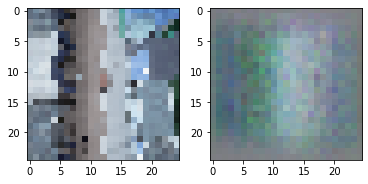

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for imgs in random.sample(list(train_dl), 1):
#         imgs, _ = data
        imgs = imgs.to(device)
#         img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        img = imgs[0].cpu().numpy()
        img = np.transpose(img, (1,2,0))
        print(img.dtype)
        print(img.shape)
        plt.imshow(img)
        out, mu, logVAR = net(imgs)
#         outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        out = out[0].cpu().numpy()
        out = np.transpose(out, (1,2,0))
        print(out.shape)
        plt.imshow(out)
        break

In [34]:
x = np.arange(4)
x

array([0, 1, 2, 3])

In [35]:
x = x.reshape((2,2))
x

array([[0, 1],
       [2, 3]])

In [12]:
t = torch.empty(3, 4, 5, 2)
t.shape

torch.Size([3, 4, 5, 2])

In [14]:
t = t.view(-1, 10)
t.shape

torch.Size([12, 10])